In [ ]:
# Import libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda ,Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import torch.autograd as autograd
import seaborn as sns

In [ ]:

#Create a function G: Z → X where Z~U(0, 1) and X~N(0, 1). 
# definition of a WGAN-gp generator model for mapping the uniform dostribution to the normal ones: 

class Generator(nn.Module):
    def __init__(self, latent_dim, layers, output_activation=None):
      
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_activation = output_activation
        self._init_layers(layers)

    def _init_layers(self, layers):
        self.module_list = nn.ModuleList()
        last_layer = self.latent_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.ReLU())
        

    def forward(self, input_tensor):
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_dim, layers):
       
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
       
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
               print(len(layers))
               self.module_list.append(nn.ReLU())
            else:   #remove this layer 
               self.module_list.append(nn.Linear(last_layer, 1)) #remove sigmoid activation for wgan-gp

    def forward(self, input_tensor):
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

In [ ]:
LEARNING_RATE = 1e-4
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
PLOT_EVERY = 1
GRID_RESOLUTION = 400
LATENT_DIM = 1

In [ ]:
class WGAN_GP():
    def __init__(self, generator, critic, noise_fn, data_fn,gradient_penalty,
                 batch_size=32, device='cuda', lr_d=1e-3, lr_g=2e-4):
        self.generator = generator
        self.generator = self.generator.to(device)
        self.critic = critic
        self.critic = self.critic.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.gradient_penalty = gradient_penalty
        self.batch_size = batch_size
        self.device = device
        #self.criterion = nn.BCELoss() #different criterion
        self.optim_d = optim.Adam(critic.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)

    def generate_samples(self, latent_vec=None, num=None):
       
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def train_step_generator(self):
        
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        loss = - torch.mean(self.critic(generated)) #self.critic is added
        loss.backward()
        self.optim_g.step()
        return loss.item()
        
    def train_step_critic(self, critic, epsilon):
       
        self.critic.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        #pred_real = self.discriminator(real_samples

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
       
        critic_real = self.critic(real_samples)
        critic_fake = self.critic(fake_samples)

        gp = self.gradient_penalty(real_samples, fake_samples, critic, epsilon) 
        loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
        
        loss_critic.backward()
        self.optim_d.step()
        return loss_critic.item()
       

In [ ]:
def gradient_penalty(real, fake, crit, epsilon):
  
    interpolate = (real* epsilon) + (fake*(1- epsilon))
    score= crit(interpolate)

    gradient= torch.autograd.grad(outputs= score,
                                  inputs= interpolate,
                                  grad_outputs=torch.ones_like(score), #grad_outputs=fake, #grad_outputs=torch.ones_like(score),
                                  create_graph=True,
                                  retain_graph=True)[0]
  
  
  
    gradient= gradient.view(len(gradient), -1)
    gradient_norm= gradient.norm(2, dim=1)
    penalty = torch.nn.MSELoss()(gradient_norm, torch.ones_like(gradient_norm))
    return penalty #, gradient

In [ ]:
def main():
    from time import time
    epochs = 200
    batches = 100
    gen = Generator(1, [64, 32, 1])
    critic= Critic(1, [64, 32, 1])

    noise_fn = lambda x: torch.randn((x, 1), device='cpu')
    data_fn = lambda x: torch.randn((x, 1), device='cpu')
    epsilon= torch.rand(32,1, requires_grad=True) #lambda x: torch.rand((x,0.2), device= 'cpu', requires_grad=True)

    wgan_gp = WGAN_GP(gen, critic, noise_fn, data_fn, gradient_penalty, device='cpu')

    gen.train()
    critic.train()

    loss_g, loss_c = [], []
    start = time()
    for epoch in range(epochs):
      
        loss_g_running = 0

        for batch in range(batches):
            loss_c_running = 0
            for _ in range(CRITIC_ITERATIONS):
                lc_ = wgan_gp.train_step_critic(critic, epsilon)
                loss_c_running += lc_


        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
            lg_ = wgan_gp.train_step_generator()
            loss_g_running += lg_
            
        loss_g.append(loss_g_running / batches)
        loss_c.append(loss_c_running / batches)
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" C={loss_c[-1]:.3f},"
             )


if __name__ == "__main__":
    main()

3
3
Epoch 1/200 (1s): G=-0.184, C=0.058,
Epoch 2/200 (2s): G=-1.015, C=-0.072,
Epoch 3/200 (4s): G=-2.456, C=-0.020,
Epoch 4/200 (5s): G=-4.141, C=0.088,
Epoch 5/200 (6s): G=-5.595, C=0.209,
Epoch 6/200 (7s): G=-7.111, C=0.345,
Epoch 7/200 (9s): G=-7.602, C=0.440,
Epoch 8/200 (10s): G=-6.204, C=0.484,
Epoch 9/200 (11s): G=2.358, C=-0.937,
Epoch 10/200 (12s): G=16.535, C=-0.454,
Epoch 11/200 (14s): G=8.332, C=-0.212,
Epoch 12/200 (15s): G=2.922, C=0.010,
Epoch 13/200 (16s): G=0.723, C=0.038,
Epoch 14/200 (17s): G=2.685, C=0.036,
Epoch 15/200 (19s): G=2.573, C=0.040,
Epoch 16/200 (20s): G=2.722, C=0.038,
Epoch 17/200 (21s): G=2.808, C=0.037,
Epoch 18/200 (23s): G=2.842, C=0.037,
Epoch 19/200 (24s): G=2.887, C=0.036,
Epoch 20/200 (25s): G=2.927, C=0.040,
Epoch 21/200 (27s): G=2.974, C=0.039,
Epoch 22/200 (28s): G=3.084, C=0.037,
Epoch 23/200 (29s): G=3.183, C=0.037,
Epoch 24/200 (30s): G=3.200, C=0.034,
Epoch 25/200 (32s): G=3.198, C=0.038,
Epoch 26/200 (33s): G=3.191, C=0.045,
Epoch 27/2

4
4
4
0


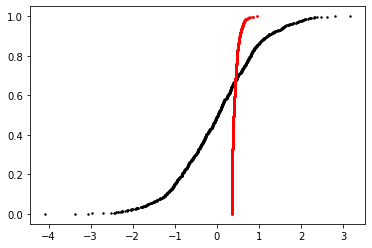

1


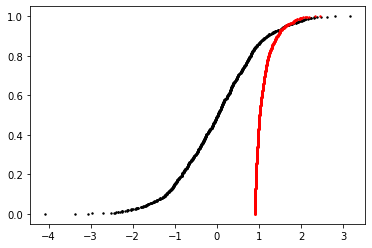

2


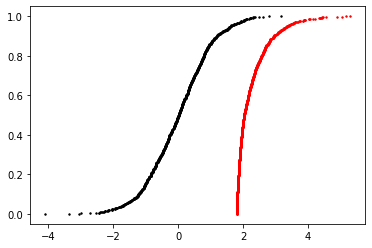

3


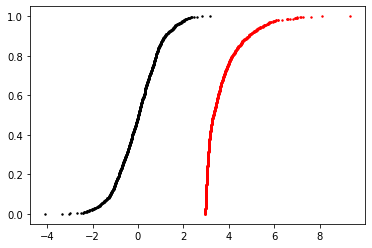

4


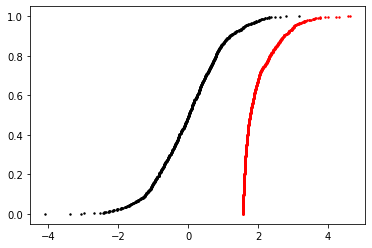

5


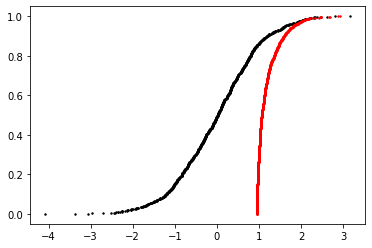

6


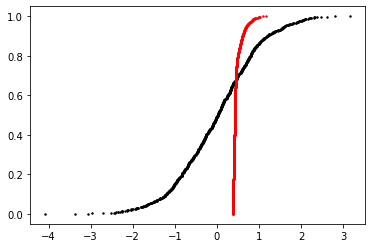

7


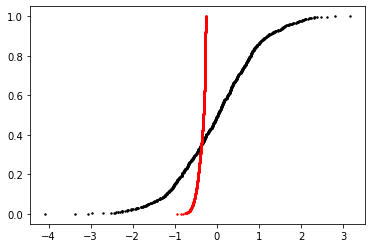

8


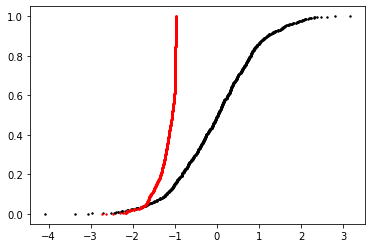

9


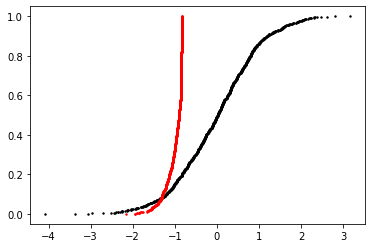

10


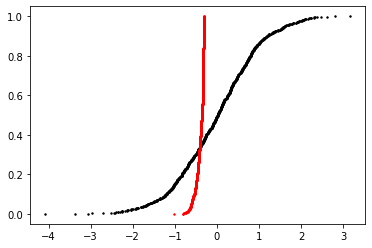

11


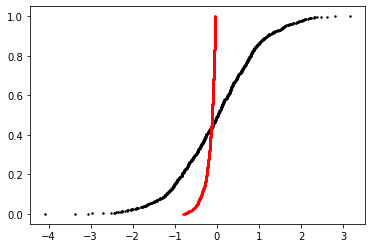

12


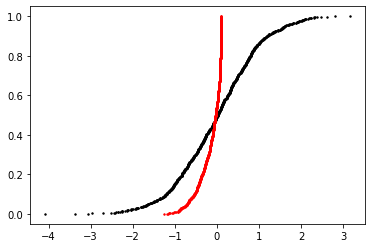

13


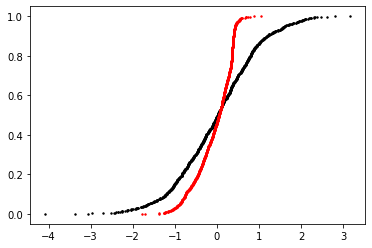

14


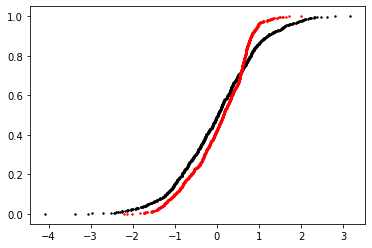

15


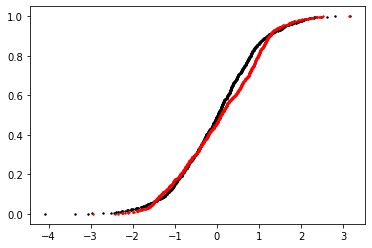

16


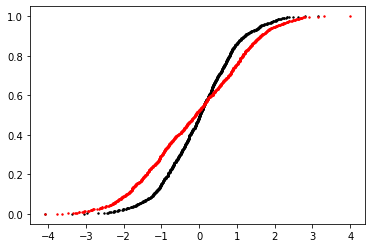

17


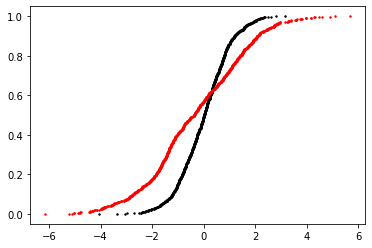

18


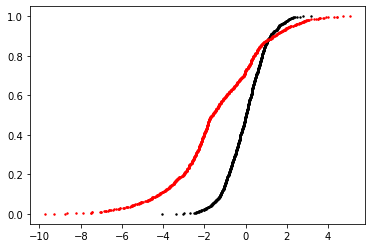

19


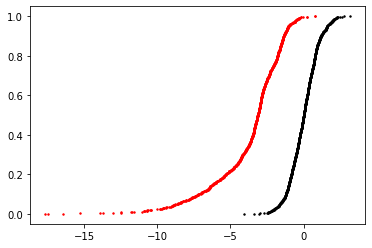

20


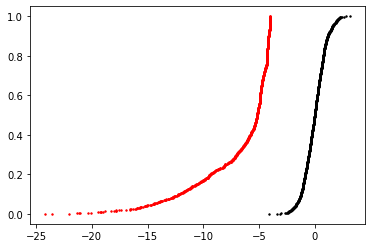

21


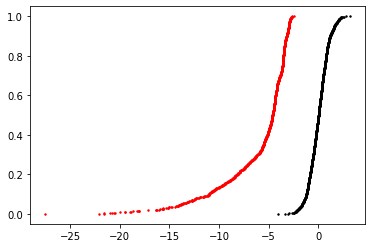

22


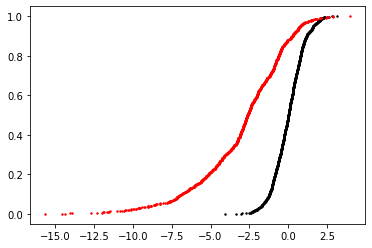

23


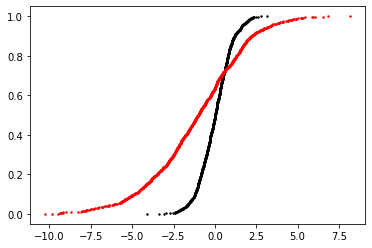

24


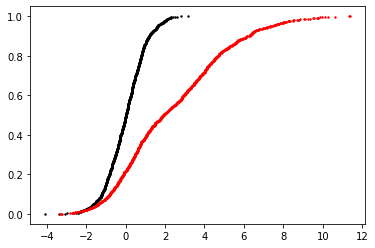

25


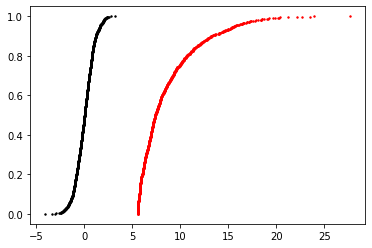

26


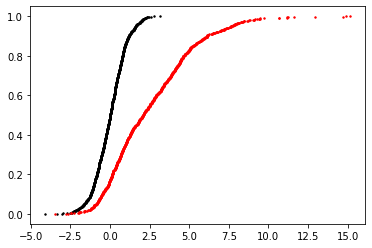

27


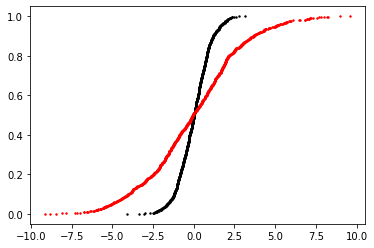

28


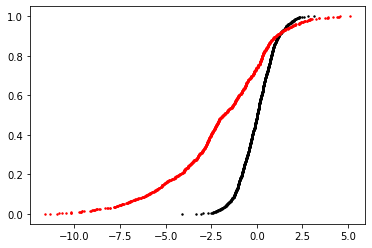

29


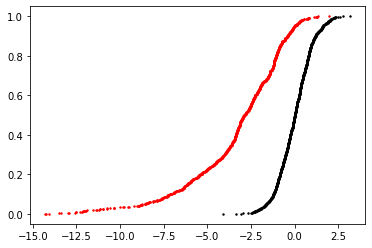

30


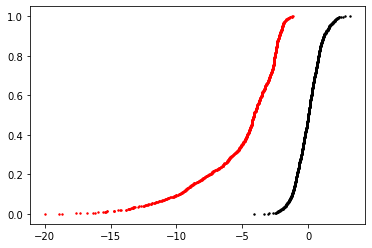

31


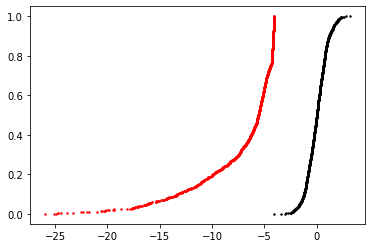

32


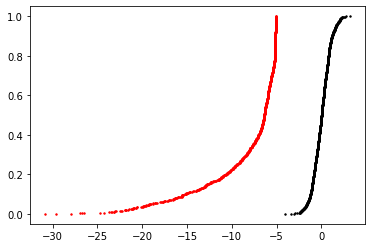

33


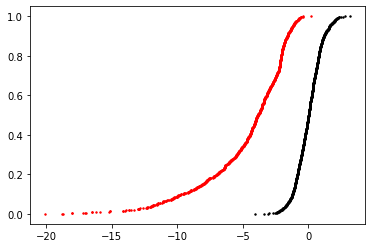

34


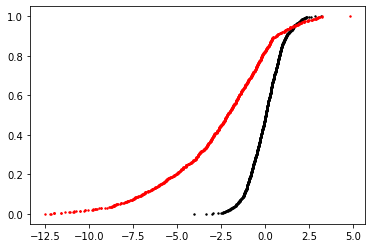

35


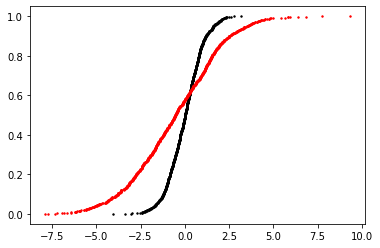

36


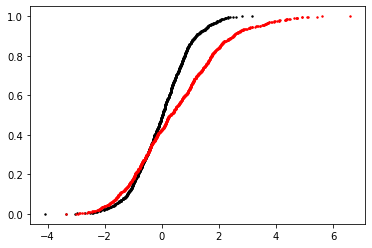

37


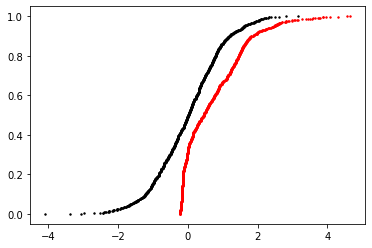

38


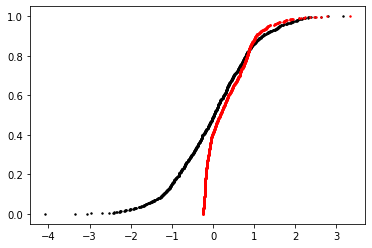

39


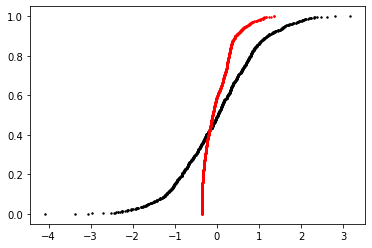

40


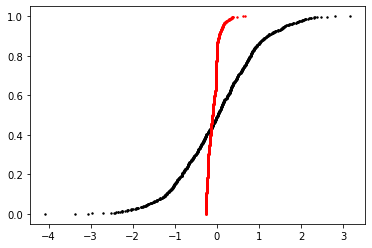

41


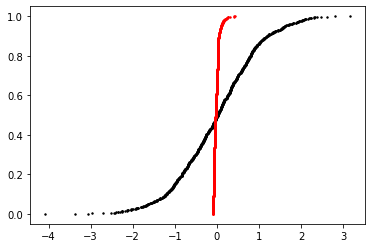

42


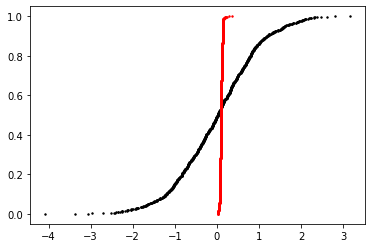

43


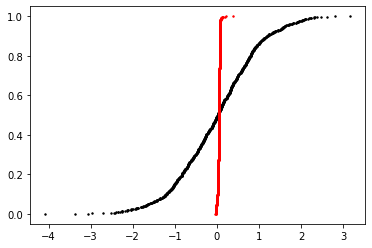

44


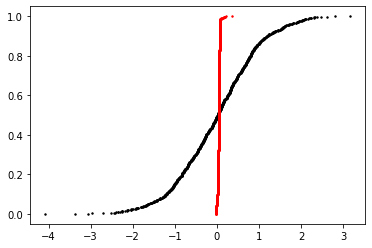

45


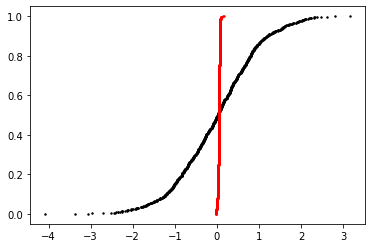

46


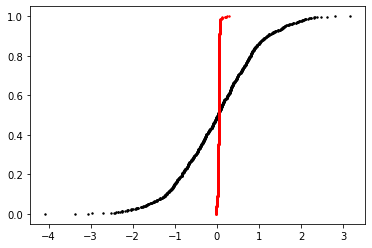

47


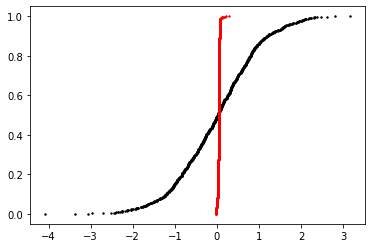

48


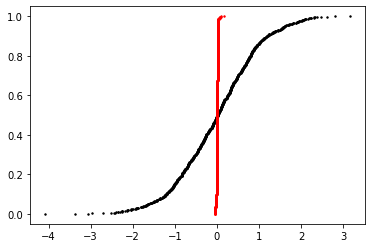

49


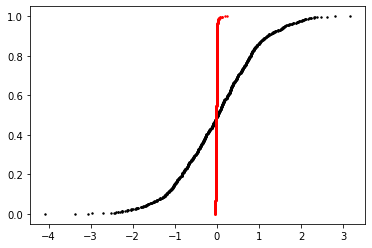

50


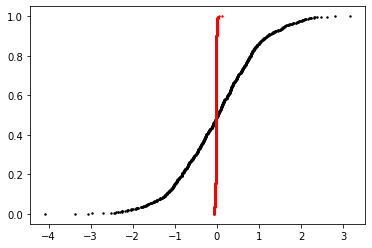

51


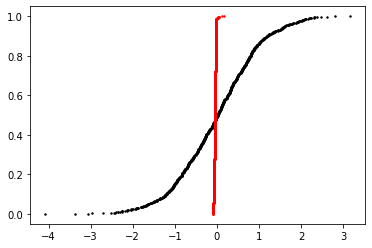

52


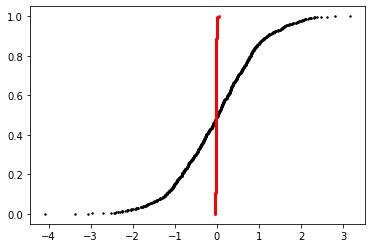

53


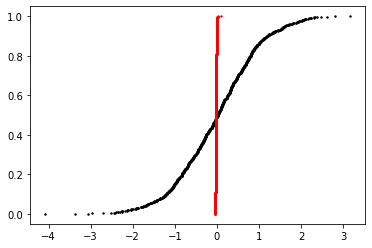

54


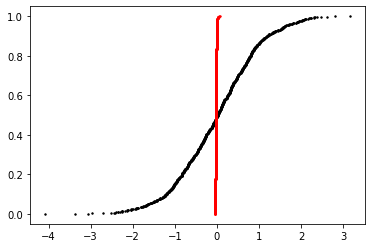

55


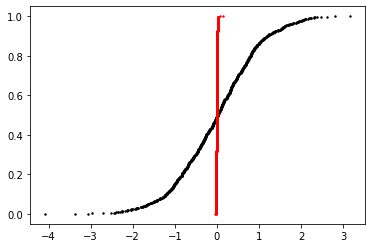

56


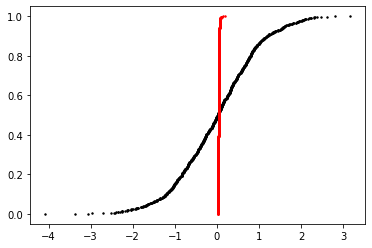

57


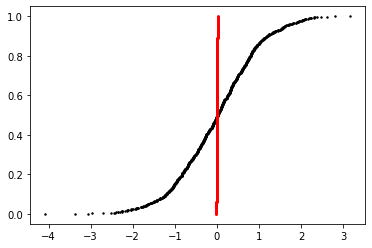

58


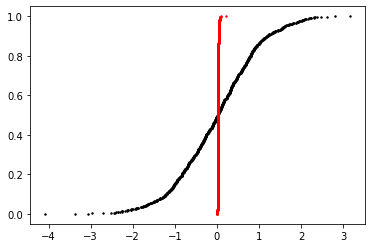

59


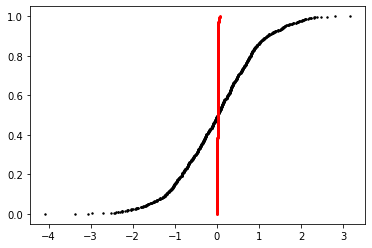

60


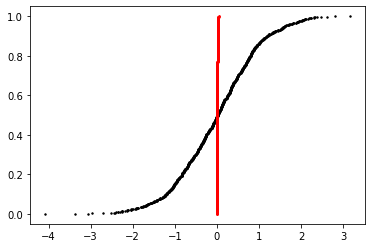

61


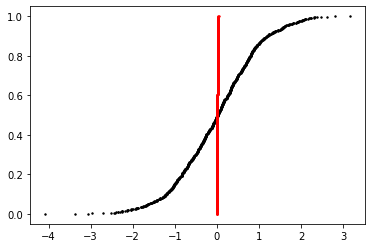

62


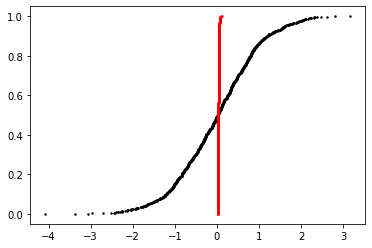

63


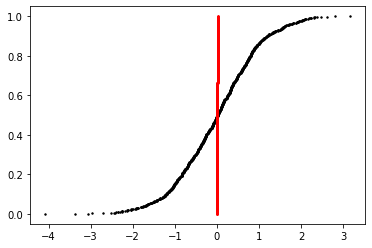

64


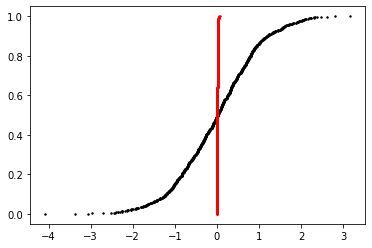

65


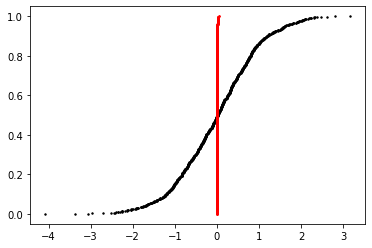

66


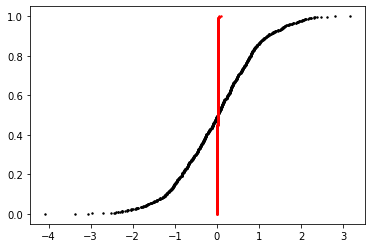

67


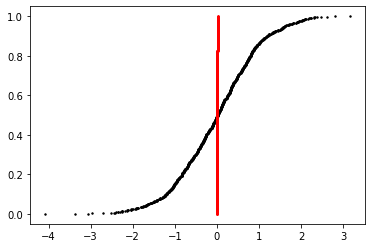

68


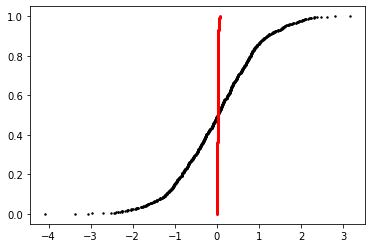

69


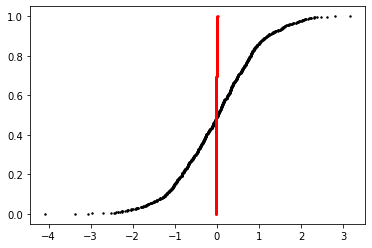

70


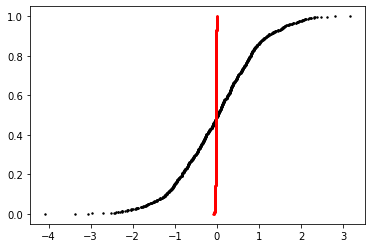

71


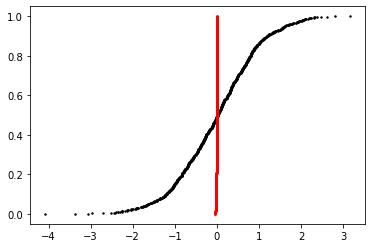

72


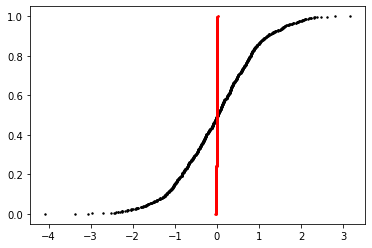

73


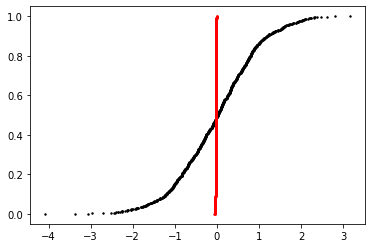

74


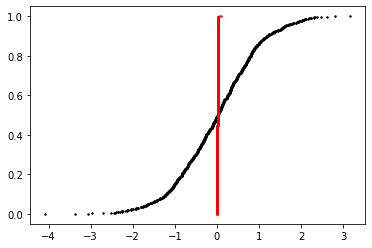

75


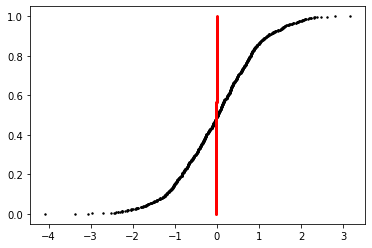

76


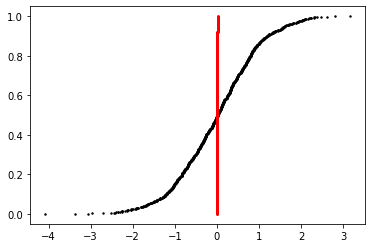

77


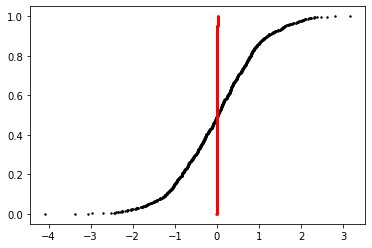

78


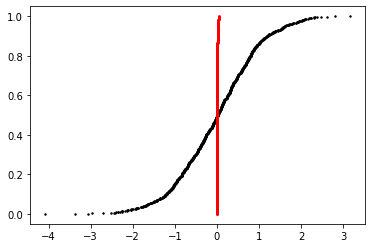

79


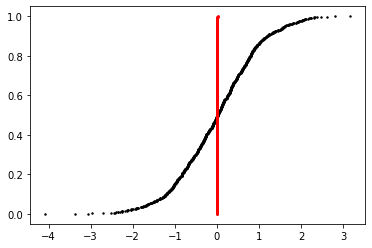

80


KeyboardInterrupt: ignored

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def noise_fn(num):
    return torch.randn((num, LATENT_DIM), device=DEVICE)

def target_fn(num):
    return torch.randn((num, 1), device=DEVICE)



gen = Generator(LATENT_DIM, [32, 32, 32, 1], output_activation=None)
critic = Critic(1, [32, 32, 32, 1])

wgan_gp = WGAN_GP(gen, critic, noise_fn, target_fn, gradient_penalty, device='cpu')

real_samples = np.random.normal(0, 1, 1000)
real_samples = np.sort(real_samples)
epsilon= torch.rand(32,1, requires_grad=True) #lambda x: torch.rand((x,0.2), device= 'cpu', requires_grad=True)
for i in range(500):
    print(i)
    for _ in range(50):
       for _ in range(5):
          wgan_gp.train_step_critic(critic, epsilon)

       wgan_gp.train_step_generator()  
    generated_samples = wgan_gp.generate_samples(num=1000).cpu().numpy().flatten()
    generated_samples = np.sort(generated_samples)
    plt.cla()
    plt.scatter(real_samples, np.linspace(0, 1, len(real_samples)), c='k', s=2)
    plt.scatter(generated_samples, np.linspace(0, 1, len(generated_samples)), c='r', s=2)
    plt.draw()
    plt.pause(0.001)
input()